# Vaccine Sentiment Classification
*by Nefeli Tavoulari*

#### In this notebook I am using a dataset provided by Dr. Saptarshi Ghosh and Soham Poddar from the Department of Computer Science and Engineering, IIT Kharagpur, India. 

# Import Packages

In [1]:
%matplotlib inline
import io
import re
import csv
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords 
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
porter = PorterStemmer()
lancaster = LancasterStemmer()
snowball = nltk.stem.SnowballStemmer('english')

import sklearn as sk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
from wordcloud import WordCloud

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer, HashingVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, accuracy_score, mean_absolute_error

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Upload dataset - Create dataframe

In [2]:
upload_train = files.upload()

Saving vs_train.csv to vs_train (9).csv


In [3]:
upload_dev = files.upload()

Saving vs_dev.csv to vs_dev (9).csv


In [4]:
df = pd.read_csv(io.BytesIO(upload_train['vs_train.csv']))
df2 = pd.read_csv(io.BytesIO(upload_dev['vs_dev.csv']))

In [5]:
print(df)

       Unnamed: 0                                              tweet  label
0               0  Sip N Shop Come thru right now #Marjais #Popul...      0
1               1  I don't know about you but My family and I wil...      1
2               2  @MSignorile Immunizations should be mandatory....      2
3               3  President Obama spoke in favor of vaccination ...      0
4               4  "@myfoxla: Arizona monitoring hundreds for mea...      0
...           ...                                                ...    ...
15971       15971  @Salon if u believe the anti-vax nutcases caus...      1
15972       15972  How do you feel about parents who don't #vacci...      0
15973       15973  70 Preschoolers Tested for Measles in Simi Val...      0
15974       15974  Finance Minister: Budget offers room to procur...      0
15975       15975  Are you up to date on vaccines? Take CDC’s vac...      2

[15976 rows x 3 columns]


In [6]:
print(df2)

      Unnamed: 0                                              tweet  label
0              0  @user They had a massive surge in with covid d...      1
1              1  Required vaccines for school: Parents and guar...      0
2              2  “@KCStar: Two more Johnson County children hav...      0
3              3  NV can do better. Which states are the best (a...      2
4              4  Nothing like killing ourselves w/ our own fear...      2
...          ...                                                ...    ...
2277        2277  RT @abc7: Number of measles cases reported in ...      0
2278        2278  Evidence points to the idea that "measles affe...      0
2279        2279  Where's @SavedYouAClick "@voxdotcom: Why you s...      2
2280        2280  Some of my favorite people have autism. If tha...      2
2281        2281  Coronavirus: The married couple behind the suc...      0

[2282 rows x 3 columns]


# Remove empty / duplicate tweets

In [7]:
df.dropna(subset = ["tweet"], inplace=True)
df2.dropna(subset = ["tweet"], inplace=True)

df.drop_duplicates(subset = ["tweet"], inplace=True)

print(df.shape)
print(df2.shape)

(15881, 3)
(2282, 3)


## Check dataset balance



In [8]:
df.groupby("label")["tweet"].count()

label
0    7385
1    2070
2    6426
Name: tweet, dtype: int64

# Text Preprocessing

In [9]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):

  text = text.lower()                                           # lowercase
  text = text.strip()                                           # remove white spaces
  text = ' '.join(re.sub("(@[A-Za-z0-9]+)"," ",text).split())   # remove twitter user accounts
  text = re.sub(r'http\S+', ' ', text)                          # remove urls
  text = re.sub('[^A-Za-z0-9]+', ' ', text)                     # remove special characters

  # perform stemming
  cleaned_text = ""
  for word in text.split() :
    if word in stop_words:                                      # remove stopwords
      continue
    temp = lemmatizer.lemmatize(word)                           # lemmatize
    #temp = snowball.stem(word)
    #temp = lancaster.stem(word)
    #temp = porter.stem(word)
    
    cleaned_text += (temp + " ")

  return cleaned_text


In [10]:
cleaned_text = []
for line in df["tweet"]:
  cleaned_text.append(clean_text(line))
cleaned_text_val = []
for line in df2["tweet"]:
  cleaned_text_val.append(clean_text(line))

# Create new column with clean text

In [11]:
df = df.assign(clean_tweet = lambda x: cleaned_text)
df2 = df2.assign(clean_tweet = lambda x: cleaned_text_val)

In [12]:
df

,Unnamed: 0,tweet,label,clean_tweet
0,0,Sip N Shop Come thru right now #Marjais #Popul...,0,sip n shop come thru right marjais popularnobo...
1,1,I don't know about you but My family and I wil...,1,know family take covid19 vaccine anytime soon
2,2,@MSignorile Immunizations should be mandatory....,2,immunization mandatory period oklahoma let kid...
3,3,President Obama spoke in favor of vaccination ...,0,president obama spoke favor vaccination child ...
4,4,"""@myfoxla: Arizona monitoring hundreds for mea...",0,arizona monitoring hundred measles linked disn...
...,...,...,...,...
15971,15971,@Salon if u believe the anti-vax nutcases caus...,1,u believe anti vax nutcase caused measles u ig...
15972,15972,How do you feel about parents who don't #vacci...,0,feel parent vaccinate kid measlesoutbreak
15973,15973,70 Preschoolers Tested for Measles in Simi Val...,0,70 preschooler tested measles simi valley
15974,15974,Finance Minister: Budget offers room to procur...,0,finance minister budget offer room procure cov...


In [13]:
df2

,Unnamed: 0,tweet,label,clean_tweet
0,0,@user They had a massive surge in with covid d...,1,massive surge covid death immediately vaccine ...
1,1,Required vaccines for school: Parents and guar...,0,required vaccine school parent guardian child ...
2,2,“@KCStar: Two more Johnson County children hav...,0,two johnson county child measles
3,3,NV can do better. Which states are the best (a...,2,nv better state best worst vaccinating kid
4,4,Nothing like killing ourselves w/ our own fear...,2,nothing like killing w fear mt milano vaccine ...
...,...,...,...,...
2277,2277,RT @abc7: Number of measles cases reported in ...,0,rt number measles case reported cali 10 year h...
2278,2278,"Evidence points to the idea that ""measles affe...",0,evidence point idea measles affect immune syst...
2279,2279,"Where's @SavedYouAClick ""@voxdotcom: Why you s...",2,vaccinate kid two minute
2280,2280,Some of my favorite people have autism. If tha...,2,favorite people autism reason bringing back di...


# Vectorize and Perform TF-IDF

## Using CountVectorizer

### Training data

In [55]:
cv = CountVectorizer(stop_words='english')
word_count_vector_train = cv.fit_transform(df['clean_tweet'])
word_count_vector_train.shape

(15881, 14831)

In [56]:
tfidf_transformer = TfidfTransformer(smooth_idf = True, use_idf = True) 
tfidf_transformer.fit(word_count_vector_train)

# print idf values sorted by ascending order - simply for debugging
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(), columns=["idf_weights"]) 
df_idf.sort_values(by=['idf_weights'])

,idf_weights
vaccin,1.471238
measl,2.346425
kid,3.188011
immun,3.248776
health,3.330810
...,...
ilk,9.979794
illegalalien,9.979794
illig,9.979794
illiter,9.979794


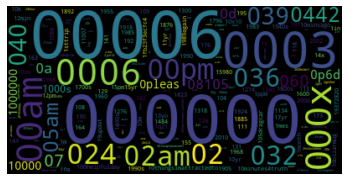

In [57]:
freq = {}
count = 0
for x in df_idf['idf_weights']:
    freq[df_idf.index[count]] = x + 1
    count += 1
wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=freq)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [58]:
count_vector_train = cv.transform(df['clean_tweet']) 

# tf-idf scores 
tf_idf_vector = tfidf_transformer.transform(count_vector_train)

In [40]:
# get tf-idf vector for first tweet 
first_tweet_vector = tf_idf_vector[0] 
 
# print scores sorted by descending order - for debugging
df3 = pd.DataFrame(first_tweet_vector.T.todense(), index=cv.get_feature_names() , columns=["tfidf"]) 
df3.sort_values(by=["tfidf"], ascending=False)

,tfidf
marja,0.650115
sipnshop,0.377496
sip,0.377496
popularnobody,0.335939
shop,0.301280
...,...
fel,0.000000
felin,0.000000
felinedistemp,0.000000
fell,0.000000


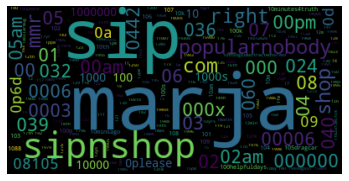

In [59]:
freq = {}
count = 0
for x in df3['tfidf']:
    freq[df3.index[count]] = x + 1
    count += 1
wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=freq)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Test Data

In [60]:
count_vector_dev = cv.transform(df2['clean_tweet']) 
tf_idf_vector_dev = tfidf_transformer.transform(count_vector_dev)

# for debugging
first_document_vector_dev = tf_idf_vector_dev[0] 
df4 = pd.DataFrame(first_document_vector_dev.T.todense(), index=cv.get_feature_names(), columns=["tfidf"]) 
df4.sort_values(by=["tfidf"], ascending=False)

,tfidf
entireti,0.386754
death,0.383359
immedi,0.320689
surg,0.299508
rollout,0.293827
...,...
feder,0.000000
federalregist,0.000000
fedora,0.000000
fee,0.000000


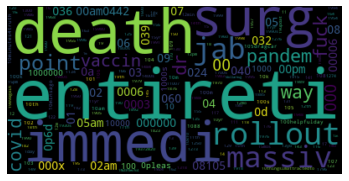

In [61]:
freq = {}
count = 0
for x in df4['tfidf']:
    freq[df4.index[count]] = x + 1
    count += 1
wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequencies=freq)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

## Perform Logistic Regression

In [62]:
x_train = pd.DataFrame.sparse.from_spmatrix(tf_idf_vector)
x_dev = pd.DataFrame.sparse.from_spmatrix(tf_idf_vector_dev)
y_train = df["label"]
y_dev = df2["label"]
x_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,14791,14792,14793,14794,14795,14796,14797,14798,14799,14800,14801,14802,14803,14804,14805,14806,14807,14808,14809,14810,14811,14812,14813,14814,14815,14816,14817,14818,14819,14820,14821,14822,14823,14824,14825,14826,14827,14828,14829,14830
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
LR = LogisticRegression(multi_class='multinomial', random_state = 0, max_iter = 1000)
LR.fit(x_train, y_train)
y_train_pred = LR.predict(x_train) 
y_dev_pred = LR.predict(x_dev) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## Evaluation metrics

In [65]:
print("Precision-Recall-F1 - Training Data :")
print(precision_recall_fscore_support(y_train, y_train_pred, average='weighted'))
print()
print("Precision-Recall-F1 - Test Data :")
print(precision_recall_fscore_support(y_dev, y_dev_pred, average='weighted'))
print()
print("Accuracy - Training Data :")
print(accuracy_score(y_train, y_train_pred))
print()
print("Accuracy - Test Data :")
print(accuracy_score(y_dev, y_dev_pred))

Precision-Recall-F1 - Training Data :
(0.8231095611823768, 0.8194698066872363, 0.8127098656548944, None)

Precision-Recall-F1 - Test Data :
(0.7189581126855128, 0.7212971078001753, 0.7135899071730929, None)

Accuracy - Training Data :
0.8194698066872363

Accuracy - Test Data :
0.7212971078001753


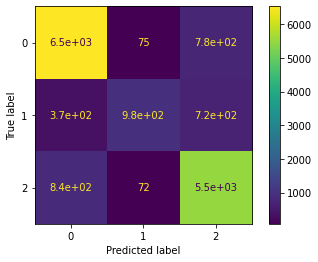

In [29]:
cm = confusion_matrix(y_train, y_train_pred, labels=LR.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LR.classes_)
disp.plot()
plt.show()

In [30]:
target_names = ['neutral', 'anti-vax', 'pro-vax']
print(classification_report(y_train, y_train_pred, target_names=target_names))
print(classification_report(y_dev, y_dev_pred, target_names=target_names))

              precision    recall  f1-score   support

     neutral       0.84      0.88      0.86      7385
    anti-vax       0.87      0.47      0.61      2070
     pro-vax       0.79      0.86      0.82      6426

    accuracy                           0.82     15881
   macro avg       0.83      0.74      0.77     15881
weighted avg       0.82      0.82      0.81     15881

              precision    recall  f1-score   support

     neutral       0.77      0.80      0.78      1065
    anti-vax       0.65      0.35      0.46       296
     pro-vax       0.68      0.74      0.71       921

    accuracy                           0.72      2282
   macro avg       0.70      0.63      0.65      2282
weighted avg       0.72      0.72      0.71      2282



## Same process using HashingVectorizer

In [168]:
hv = HashingVectorizer(n_features=2**15)
tfidf_transformer = TfidfTransformer(smooth_idf = True, use_idf = True) 

word_count_vector_train = hv.fit_transform(df['clean_tweet'])
tf_idf_vector = tfidf_transformer.fit(word_count_vector_train)
count_vector_train = hv.transform(df['clean_tweet']) 
tf_idf_vector = tfidf_transformer.transform(count_vector_train)

count_vector_dev = hv.transform(df2['clean_tweet']) 
tf_idf_vector_dev = tfidf_transformer.transform(count_vector_dev)

x_train = pd.DataFrame.sparse.from_spmatrix(tf_idf_vector)
x_dev = pd.DataFrame.sparse.from_spmatrix(tf_idf_vector_dev)
y_train = df["label"]
y_dev = df2["label"]

LR = LogisticRegression(multi_class='multinomial', random_state = 0, max_iter = 1000)
LR.fit(x_train, y_train)

y_train_pred = LR.predict(x_train) 
y_dev_pred = LR.predict(x_dev) 

## Evaluation Metrics


In [169]:
print("Precision-Recall-F1 - Training Data :")
print(precision_recall_fscore_support(y_train, y_train_pred, average='weighted'))
print()
print("Precision-Recall-F1 - Test Data :")
print(precision_recall_fscore_support(y_dev, y_dev_pred, average='weighted'))
print()
print("Accuracy - Training Data :")
print(accuracy_score(y_train, y_train_pred))
print()
print("Accuracy - Test Data :")
print(accuracy_score(y_dev, y_dev_pred))

Precision-Recall-F1 - Training Data :
(0.8322713774583604, 0.8282853724576538, 0.8224040089219653, None)

Precision-Recall-F1 - Test Data :
(0.7162484737693444, 0.7169149868536372, 0.70836871558496, None)

Accuracy - Training Data :
0.8282853724576538

Accuracy - Test Data :
0.7169149868536372


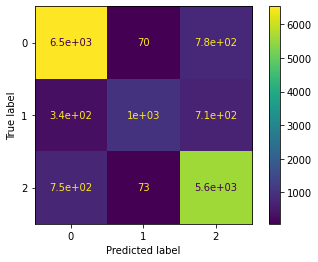

In [170]:
cm = confusion_matrix(y_train, y_train_pred, labels=LR.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LR.classes_)
disp.plot()
plt.show()

In [171]:
target_names = ['neutral', 'anti-vax', 'pro-vax']
print(classification_report(y_train, y_train_pred, target_names=target_names))
print(classification_report(y_dev, y_dev_pred, target_names=target_names))

              precision    recall  f1-score   support

     neutral       0.86      0.88      0.87      7385
    anti-vax       0.88      0.49      0.63      2070
     pro-vax       0.79      0.87      0.83      6426

    accuracy                           0.83     15881
   macro avg       0.84      0.75      0.78     15881
weighted avg       0.83      0.83      0.82     15881

              precision    recall  f1-score   support

     neutral       0.75      0.80      0.77      1065
    anti-vax       0.71      0.36      0.48       296
     pro-vax       0.68      0.73      0.71       921

    accuracy                           0.72      2282
   macro avg       0.71      0.63      0.65      2282
weighted avg       0.72      0.72      0.71      2282



## Same process using TfidfVectorizer

In [ ]:
tfidfvectorizer = TfidfVectorizer()
LR = LogisticRegression()

word_count_vector_train = tfidfvectorizer.fit_transform(df['clean_tweet'])
word_count_vector_dev = tfidfvectorizer.transform(df2['clean_tweet'])

x_train = pd.DataFrame.sparse.from_spmatrix(word_count_vector_train)
x_dev = pd.DataFrame.sparse.from_spmatrix(word_count_vector_dev)
y_train = df["label"]
y_dev = df2["label"]

#scaler = StandardScaler()
#scaler = MinMaxScaler()
#x_train = scaler.fit_transform(x_train)
#x_dev = scaler.transform(x_dev)

parameters={'penalty':['l2','none'],'C':[1,3,5], 'solver':['newton-cg', 'lbfgs'], 'multi_class':['multinomial'], 'max_iter':[500, 1000]}
gscv = GridSearchCV(LR, parameters, scoring='accuracy', n_jobs=-1, cv=10)
grid_search = gscv.fit(x_train, y_train)
grid_search.best_params_

# LR = LogisticRegression(multi_class='multinomial', max_iter=1000)
# LR.fit(x_train, y_train)

# y_train_pred = LR.predict(x_train) 
# y_dev_pred = LR.predict(x_dev) 

## Evaluation metrics

In [32]:
print("Precision-Recall-F1 - Training Data :")
print(precision_recall_fscore_support(y_train, y_train_pred, average='weighted'))
print()
print("Precision-Recall-F1 - Test Data :")
print(precision_recall_fscore_support(y_dev, y_dev_pred, average='weighted'))
print()
print("Accuracy - Training Data :")
print(accuracy_score(y_train, y_train_pred))
print()
print("Accuracy - Test Data :")
print(accuracy_score(y_dev, y_dev_pred))

Precision-Recall-F1 - Training Data :
(0.8243253080270819, 0.8209810465335936, 0.8149087837596175, None)

Precision-Recall-F1 - Test Data :
(0.7120015000759048, 0.7138475021910605, 0.7065264618395091, None)

Accuracy - Training Data :
0.8209810465335936

Accuracy - Test Data :
0.7138475021910605


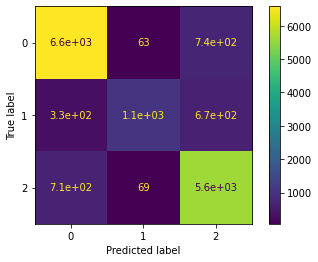

In [17]:
cm = confusion_matrix(y_train, y_train_pred, labels=LR.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LR.classes_)
disp.plot()
plt.show()

In [18]:
target_names = ['neutral', 'anti-vax', 'pro-vax']
print(classification_report(y_train, y_train_pred, target_names=target_names))
print(classification_report(y_dev, y_dev_pred, target_names=target_names))

              precision    recall  f1-score   support

     neutral       0.86      0.89      0.88      7385
    anti-vax       0.89      0.51      0.65      2070
     pro-vax       0.80      0.88      0.84      6426

    accuracy                           0.84     15881
   macro avg       0.85      0.76      0.79     15881
weighted avg       0.84      0.84      0.83     15881

              precision    recall  f1-score   support

     neutral       0.77      0.79      0.78      1065
    anti-vax       0.70      0.40      0.51       296
     pro-vax       0.69      0.75      0.72       921

    accuracy                           0.73      2282
   macro avg       0.72      0.65      0.67      2282
weighted avg       0.73      0.73      0.72      2282



In [19]:
print("MAE - training : ", mean_absolute_error(y_train, y_train_pred))
print("MAE - testing : ", mean_absolute_error(y_dev, y_dev_pred))

MAE - training :  0.25420313582268117
MAE - testing :  0.4474145486415425


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


KeyboardInterrupt: ignored

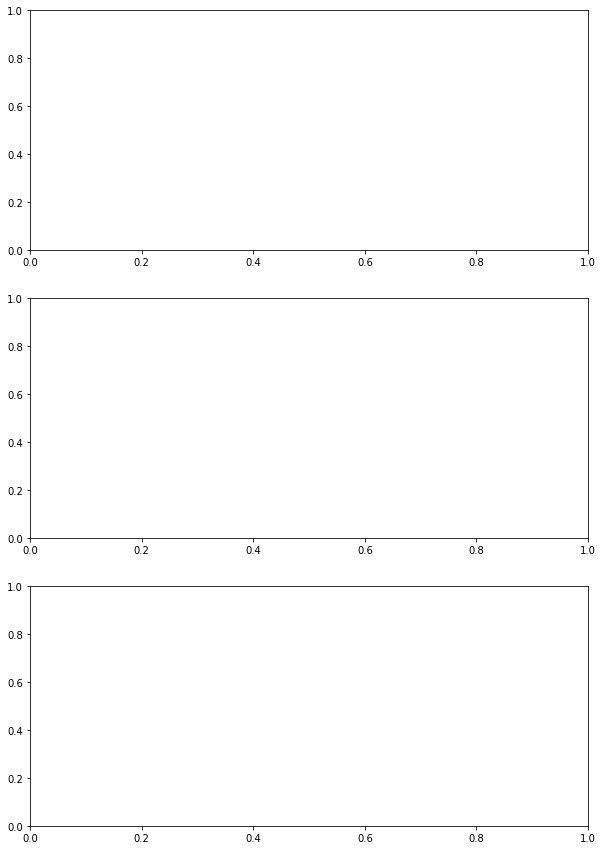

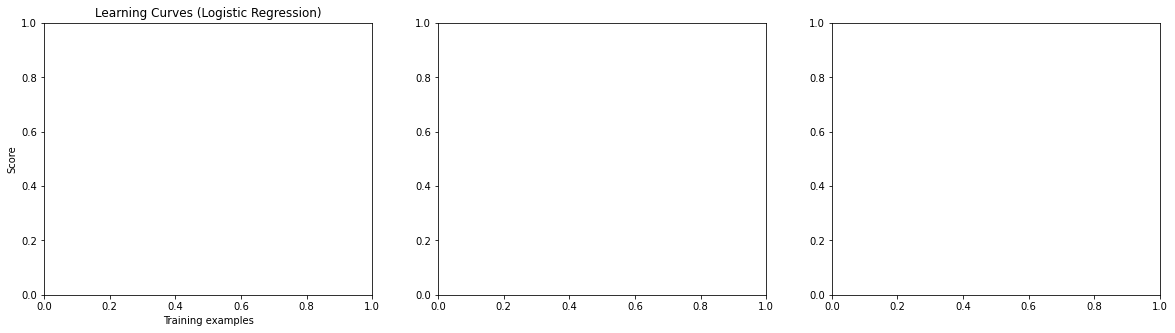

In [177]:
# from sklearn.model_selection import learning_curve
# from sklearn.model_selection import ShuffleSplit
# def plot_learning_curve(
#     estimator,
#     title,
#     X,
#     y,
#     axes=None,
#     ylim=None,
#     cv=None,
#     n_jobs=None,
#     train_sizes=np.linspace(0.1, 1.0, 5),
# ):
#     """
#     Parameters
#     ----------
#     X : array-like of shape (n_samples, n_features)
#         Training vector, where ``n_samples`` is the number of samples and
#         ``n_features`` is the number of features.

#     y : array-like of shape (n_samples) or (n_samples, n_features)
#         Target relative to ``X`` for classification or regression;
#         None for unsupervised learning.

#     axes : array-like of shape (3,), default=None
#         Axes to use for plotting the curves.

#     ylim : tuple of shape (2,), default=None
#         Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

#     cv : int, cross-validation generator or an iterable, default=None
#         Determines the cross-validation splitting strategy.
#         Possible inputs for cv are:

#           - None, to use the default 5-fold cross-validation,
#           - integer, to specify the number of folds.
#           - :term:`CV splitter`,
#           - An iterable yielding (train, test) splits as arrays of indices.

#         For integer/None inputs, if ``y`` is binary or multiclass,
#         :class:`StratifiedKFold` used. If the estimator is not a classifier
#         or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

#         Refer :ref:`User Guide <cross_validation>` for the various
#         cross-validators that can be used here.

#     train_sizes : array-like of shape (n_ticks,)
#         Relative or absolute numbers of training examples that will be used to
#         generate the learning curve. If the ``dtype`` is float, it is regarded
#         as a fraction of the maximum size of the training set (that is
#         determined by the selected validation method), i.e. it has to be within
#         (0, 1]. Otherwise it is interpreted as absolute sizes of the training
#         sets. Note that for classification the number of samples usually have
#         to be big enough to contain at least one sample from each class.
#         (default: np.linspace(0.1, 1.0, 5))
#     """
#     if axes is None:
#         _, axes = plt.subplots(1, 3, figsize=(20, 5))

#     axes[0].set_title(title)
#     if ylim is not None:
#         axes[0].set_ylim(*ylim)
#     axes[0].set_xlabel("Training examples")
#     axes[0].set_ylabel("Score")

#     train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
#         estimator,
#         X,
#         y,
#         cv=cv,
#         n_jobs=n_jobs,
#         train_sizes=train_sizes,
#         return_times=True,
#     )
#     train_scores_mean = np.mean(train_scores, axis=1)
#     train_scores_std = np.std(train_scores, axis=1)
#     test_scores_mean = np.mean(test_scores, axis=1)
#     test_scores_std = np.std(test_scores, axis=1)
#     fit_times_mean = np.mean(fit_times, axis=1)
#     fit_times_std = np.std(fit_times, axis=1)

#     # Plot learning curve
#     axes[0].grid()
#     axes[0].fill_between(
#         train_sizes,
#         train_scores_mean - train_scores_std,
#         train_scores_mean + train_scores_std,
#         alpha=0.1,
#         color="r",
#     )
#     axes[0].fill_between(
#         train_sizes,
#         test_scores_mean - test_scores_std,
#         test_scores_mean + test_scores_std,
#         alpha=0.1,
#         color="g",
#     )
#     axes[0].plot(
#         train_sizes, train_scores_mean, "o-", color="r", label="Training score"
#     )
#     axes[0].plot(
#         train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
#     )
#     axes[0].legend(loc="best")

#     # Plot n_samples vs fit_times
#     axes[1].grid()
#     axes[1].plot(train_sizes, fit_times_mean, "o-")
#     axes[1].fill_between(
#         train_sizes,
#         fit_times_mean - fit_times_std,
#         fit_times_mean + fit_times_std,
#         alpha=0.1,
#     )
#     axes[1].set_xlabel("Training examples")
#     axes[1].set_ylabel("fit_times")
#     axes[1].set_title("Scalability of the model")

#     # Plot fit_time vs score
#     axes[2].grid()
#     axes[2].plot(fit_times_mean, test_scores_mean, "o-")
#     axes[2].fill_between(
#         fit_times_mean,
#         test_scores_mean - test_scores_std,
#         test_scores_mean + test_scores_std,
#         alpha=0.1,
#     )
#     axes[2].set_xlabel("fit_times")
#     axes[2].set_ylabel("Score")
#     axes[2].set_title("Performance of the model")

#     return plt


# fig, axes = plt.subplots(3, 1, figsize=(10, 15))

# title = "Learning Curves (Logistic Regression)"
# # Cross validation with 100 iterations to get smoother mean test and train
# # score curves, each time with 20% data randomly selected as a validation set.
# cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

# estimator = LR
# plot_learning_curve(estimator, title, x_train, y_train, cv=cv, n_jobs=-1)

# plt.show()

## Experimenting with other classifiers

### Decision Tree

In [178]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=0).fit(x_train, y_train)
y_train_pred = dt.predict(x_train) 
y_dev_pred = dt.predict(x_dev) 

In [179]:
print("Precision-Recall-F1 - Training Data :")
print(precision_recall_fscore_support(y_train, y_train_pred, average='weighted'))
print()
print("Precision-Recall-F1 - Test Data :")
print(precision_recall_fscore_support(y_dev, y_dev_pred, average='weighted'))
print()
print("Accuracy - Training Data :")
print(accuracy_score(y_train, y_train_pred))
print()
print("Accuracy - Test Data :")
print(accuracy_score(y_dev, y_dev_pred))

Precision-Recall-F1 - Training Data :
(0.9937090854416717, 0.9937031673068446, 0.9937028749762473, None)

Precision-Recall-F1 - Test Data :
(0.6581820737591939, 0.6599474145486416, 0.6580869922827265, None)

Accuracy - Training Data :
0.9937031673068446

Accuracy - Test Data :
0.6599474145486416


### MLP

In [180]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(random_state=1, max_iter=300).fit(x_train, y_train)
y_train_pred = mlp.predict(x_train) 
y_dev_pred = mlp.predict(x_dev) 

In [181]:
print("Precision-Recall-F1 - Training Data :")
print(precision_recall_fscore_support(y_train, y_train_pred, average='weighted'))
print()
print("Precision-Recall-F1 - Test Data :")
print(precision_recall_fscore_support(y_dev, y_dev_pred, average='weighted'))
print()
print("Accuracy - Training Data :")
print(accuracy_score(y_train, y_train_pred))
print()
print("Accuracy - Test Data :")
print(accuracy_score(y_dev, y_dev_pred))

Precision-Recall-F1 - Training Data :
(0.9935329598750031, 0.99351426232605, 0.9935186401537495, None)

Precision-Recall-F1 - Test Data :
(0.6201623639210349, 0.6148115687992989, 0.6168783844560961, None)

Accuracy - Training Data :
0.99351426232605

Accuracy - Test Data :
0.6148115687992989


### BernoulliNB

In [182]:
from sklearn.naive_bayes import BernoulliNB
brnl = BernoulliNB().fit(x_train, y_train)
y_train_pred = brnl.predict(x_train) 
y_dev_pred = brnl.predict(x_dev) 

In [183]:
print("Precision-Recall-F1 - Training Data :")
print(precision_recall_fscore_support(y_train, y_train_pred, average='weighted'))
print()
print("Precision-Recall-F1 - Test Data :")
print(precision_recall_fscore_support(y_dev, y_dev_pred, average='weighted'))
print()
print("Accuracy - Training Data :")
print(accuracy_score(y_train, y_train_pred))
print()
print("Accuracy - Test Data :")
print(accuracy_score(y_dev, y_dev_pred))

Precision-Recall-F1 - Training Data :
(0.8000341937937687, 0.7883004848561174, 0.7779523018966668, None)

Precision-Recall-F1 - Test Data :
(0.70874036513442, 0.6950043821209465, 0.6807082277488266, None)

Accuracy - Training Data :
0.7883004848561174

Accuracy - Test Data :
0.6950043821209465
